[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


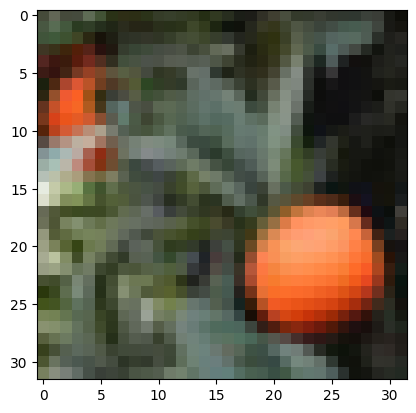

In [2]:
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
from tqdm import tqdm

def one_hot(y, n_values):
    return np.eye(n_values)[y.flatten()]

def reverse_one_hot(y):
    return np.argmax(y, axis=-1)

def random_horizontal_flip(X, prob=0.5):
    flipped = X.copy()
    flip_mask = np.random.rand(len(X)) < prob
    flipped[flip_mask] = flipped[flip_mask][:, :, ::-1, :]  # 좌우 반전
    return flipped


def show_image(X, y):
    print(y)
    plt.imshow(X, cmap='gray' if X.shape[2] == 1 else None)


np.random.seed(0)


X_train = np.load("train_data.npy")  # (50000, 3, 32, 32)
X_train = X_train.transpose(0, 2, 3, 1) / 255.0  # (50000, 32, 32, 3)

#y_train = np.load("train_fine_labels.npy")
y_train = np.load("train_coarse_labels.npy")
y_train = y_train.reshape(-1, 1)


num_total = X_train.shape[0]
num_val = num_total // 10
num_test = num_total // 10
num_train = num_total - num_val - num_test

indices = np.arange(num_total)
np.random.shuffle(indices)

train_idx = indices[:num_train]
val_idx = indices[num_train:num_train + num_val]
test_idx = indices[num_train + num_val:]

X_train_split = X_train[train_idx]
y_train_split = y_train[train_idx]

X_validate = X_train[val_idx]
y_validate = y_train[val_idx]

X_test = X_train[test_idx]
y_test = y_train[test_idx]




NUM_CLASSES = 20
y_train = one_hot(y_train, 20)
y_train_split = one_hot(y_train_split, NUM_CLASSES)
y_validate = one_hot(y_validate, NUM_CLASSES)
y_test = one_hot(y_test, NUM_CLASSES)

def show_image(X, y):
    print(y)
    plt.imshow(X, cmap='gray' if X.shape[2] == 1 else None)
    plt.show()

show_image(X_validate[0], y_validate[0])


In [3]:
class Layer:
    cache_X = None
    learn_rate = 0.001

    def forward(self, X):
        self.cache_X = X.copy()

    def backward(self, grad_in):
        raise NotImplementedError


def generate_regions(X, dim, stride):
    assert X.shape[1] >= dim
    assert X.shape[2] >= dim
    for fh, h in enumerate(range(0, X.shape[1] - dim + 1, stride)):
        for fw, w in enumerate(range(0, X.shape[2] - dim + 1, stride)):
            yield fh, fw, np.s_[:, h:h + dim, w:w + dim, :]


class Conv2D(Layer):
    W = None
    b = None
    out_nchannel = 0
    dim = 0
    stride = 0
    pad = 0

    def __init__(self, out_nchannel, dim, stride, pad):
        self.out_nchannel = out_nchannel
        self.dim = dim
        self.stride = stride
        self.pad = pad
        self.b = np.zeros(self.out_nchannel)

    def forward(self, X):
        super().forward(X)
        out_nchannel, dim, stride, pad = self.out_nchannel, self.dim, self.stride, self.pad
        if self.W is None:
            self.W = np.random.randn(
                dim, dim, X.shape[-1], out_nchannel) * np.sqrt(
                    2 / (X.shape[1] * X.shape[2] * X.shape[3]))
        W, b = self.W, self.b

        X = np.pad(X, ((0, ), (pad, ), (pad, ), (0, )))
        WX = np.zeros((len(X), (X.shape[1] - W.shape[0]) // stride + 1,
                       (X.shape[2] - W.shape[1]) // stride + 1, out_nchannel))

        for fh, fw, slice in generate_regions(X, dim, stride):
            WX[:, fh, fw, :] = np.tensordot(X[slice], W, axes=3)
        return WX + b

    def backward(self, grad_in):
        X = self.cache_X
        dX = np.zeros_like(X, dtype=float)
        dW = np.zeros_like(self.W)
        db = np.zeros_like(self.b)
        dim, stride, pad = self.dim, self.stride, self.pad
        X = np.pad(X, ((0, ), (pad, ), (pad, ), (0, )))
        dX_pad = np.zeros_like(X, dtype=float)

        for fh, fw, slice in generate_regions(X, dim, stride):
            grad_in_slice = grad_in[:, fh, fw, newaxis, newaxis, newaxis, :]
            dX_pad[slice] += np.sum(self.W * grad_in_slice, axis=-1)
            dW += np.sum(X[slice][..., newaxis] * grad_in_slice, axis=0)
            db += np.sum(grad_in_slice, axis=0).squeeze()
        dX = dX_pad[:, pad:-pad, pad:-pad, :] if pad > 0 else dX_pad
        self.W -= dW * self.learn_rate
        self.b -= db * self.learn_rate
        # print('dW mean=', np.mean(dW), '\ndb mean=', np.mean(db))
        return dX


class ReLU(Layer):

    def forward(self, X):
        super().forward(X)
        return np.maximum(X, 0)

    def backward(self, grad_in):
        dX = grad_in.copy()
        dX[self.cache_X <= 0] = 0
        return dX


class MaxPool2D(Layer):
    dim = 0
    stride = 0

    def __init__(self, dim, stride):
        self.dim = dim
        self.stride = stride

    def forward(self, X):
        super().forward(X)
        dim, stride = self.dim, self.stride
        out_shape = ((X.shape[1] - dim) // stride + 1,
                     (X.shape[2] - dim) // stride + 1, X.shape[3])
        y = np.zeros((len(X), ) + out_shape)
        for fh, fw, slice in generate_regions(X, dim, stride):
            y[:, fh, fw, :] = np.max(X[slice], axis=(1, 2))
        return y

    def backward(self, grad_in):
        X = self.cache_X
        dim, stride = self.dim, self.stride
        dX = np.zeros_like(X, dtype=float)
        for fh, fw, slice in generate_regions(X, dim, stride):
            xs = X[slice]
            indices = np.indices((xs.shape[0], xs.shape[-1]))
            max_indices = (indices[0], ) + np.unravel_index(
                xs.reshape((xs.shape[0], -1, xs.shape[-1])).argmax(axis=1),
                xs.shape[1:-1]) + (indices[1], )
            mask = np.zeros_like(xs)
            mask[max_indices] = 1
            dX[slice] += mask * grad_in[:, fh, newaxis, fw, newaxis, :]
        return dX


class Flatten(Layer):
    def forward(self, X):
        super().forward(X)
        return X.reshape((len(X), -1))

    def backward(self, grad_in):
        return grad_in.reshape(self.cache_X.shape)


class Dense(Layer):
    W = None
    b = None
    out_dim = 0

    def __init__(self, out_dim):
        self.out_dim = out_dim
        self.b = np.zeros(out_dim)

    def forward(self, X):
        super().forward(X)
        in_dim = X.shape[-1]
        if self.W is None:
            self.W = np.random.randn(in_dim, self.out_dim) * np.sqrt(
                2 / in_dim)
        return X @ self.W + self.b

    def backward(self, grad_in):
        X = self.cache_X
        dX = grad_in @ self.W.T
        dW = X.T @ grad_in
        db = np.sum(grad_in, axis=0)
        self.W -= dW * self.learn_rate
        self.b -= db * self.learn_rate
        return dX


def softmax(X, axis=-1, epsilon=1e-9):
    e_x = np.exp(X - np.max(X, axis=axis, keepdims=True))
    probs = e_x / e_x.sum(axis=axis, keepdims=True)
    return probs


class SoftmaxCrossEntropy(Layer):
    cache_grad = None

    def forward(self, X, y):
        super().forward(X)
        m = len(X)
        y_hat = softmax(X)
        loss = (-1 / m) * np.log(y_hat[y == 1]).sum()
        self.cache_grad = (y_hat - y) / m
        return y_hat, loss

    def backward(self, grad_in):
        return self.cache_grad


class Dropout(Layer):
    def __init__(self, rate):
        self.rate = rate
        self.mask = None

    def forward(self, X):
        self.mask = np.random.binomial(1, 1 - self.rate, size=X.shape)
        return X * self.mask

    def backward(self, grad_in):
        return grad_in * self.mask


In [4]:
class Model:
    layers = []
    learn_rate = 0

    def __init__(self, layers, learn_rate=0.001):
        for layer in layers:
            layer.learn_rate = learn_rate
        self.layers = layers
        self.learn_rate = learn_rate

    def forward(self, X, y=None):
        m = len(X)
        for layer in self.layers[:-1]:
            X = layer.forward(X)
        if y is None:
            return softmax(X)
        assert len(y) == m
        y_hat, loss = self.layers[-1].forward(X, y)
        return y_hat, loss

    def backward(self):
        grad = 1
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def fit(self,
            X_train,
            y_train,
            X_validate,
            y_validate,
            epochs=1,
            batch_size=32):
        n_sample = len(X_train)
        n_batch = (n_sample - 1) // batch_size + 1
        y_pred = np.zeros_like(y_train)
        for epoch in range(epochs):
            print(f"Epoch {epoch+1} ================")
            with tqdm(total=n_batch) as t:
                tot_loss = tot_acc = 0
                for i in range(n_batch):
                    batch = range(batch_size * i,
                                  min(batch_size * (i + 1), n_sample))

                    y_hat, loss = self.forward(random_horizontal_flip(X_train[batch]), y_train[batch])
                    acc = (1 / len(batch)) * np.sum(
                        reverse_one_hot(y_hat) == reverse_one_hot(
                            y_train[batch]))
                    y_pred[batch] = y_hat

                    grad = self.backward()

                    tot_loss += loss
                    tot_acc += acc
                    if (i + 1) % 32 == 0 or i + 1 == n_batch:
                        t.set_postfix({
                            'avg_loss': tot_loss / (i + 1),
                            'avg_accuracy': tot_acc / (i + 1),
                            'max_abs_gradient': np.max(abs(grad))
                        })
                        cur_n_batch = i % 32 + 1
                        t.update(cur_n_batch)
            print("Validation:")
            val_y_hat, val_loss, acc = self.evaluate(X_validate, y_validate)
            print(f"loss: {val_loss}, accuracy: {acc}")



    def predict(self, X, batch_size=32):
        y_pred = []
        n_sample = len(X)
        n_batch = (n_sample - 1) // batch_size + 1
        for i in tqdm(range(n_batch)):
            batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
            y_hat = self.forward(X[batch])
            y_pred.append(y_hat)
        return np.concatenate(y_pred)

    def evaluate(self, X, y, batch_size=32):
        y_pred = []
        n_sample = len(X)
        n_batch = (n_sample - 1) // batch_size + 1
        tot_loss = 0
        correct = 0
        for i in tqdm(range(n_batch)):
            batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
            y_hat, loss = self.forward(X[batch], y[batch])
            y_pred.append(y_hat)
            tot_loss += loss
            correct += np.sum(
                reverse_one_hot(y_hat) == reverse_one_hot(y[batch])
            )
        accuracy = correct / n_sample
        return np.concatenate(y_pred), tot_loss / n_batch, accuracy

    def get_weights(self):
        weights = []
        for layer in self.layers:
            if hasattr(layer, 'W'):
                weights.append(layer.W)
            if hasattr(layer, 'b'):
                weights.append(layer.b)
        return weights

    def set_weights(self, weights):
        weight_iter = iter(weights)
        for layer in self.layers:
            if hasattr(layer, 'W'):
                layer.W = np.array(next(weight_iter))
            if hasattr(layer, 'b'):
                layer.b = np.array(next(weight_iter))


In [6]:
np.random.seed(0)   ##deterministic weights get하기

model = Model([
    Conv2D(32, 3, 1, 1),
    ReLU(),
    MaxPool2D(2, 2),
    Conv2D(64, 3, 1, 1),
    ReLU(),
    Dropout(0.3),
    MaxPool2D(2, 2),
    Conv2D(128, 3, 1, 1),
    ReLU(),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(256),#512, relu 추가
    Dense(64),#256, relu 추가
    Dense(20),
    SoftmaxCrossEntropy()
],
              learn_rate=0.01)

# model.predict(X_train[0:1]) ## to initialize the weights
# model.get_weights()[0][0][0][0]




In [7]:
#model.fit(X_train, y_train, X_validate, y_validate, epochs=10)
X_train_flip = X_train_split[:, :, ::-1, :]  # 좌우 반전
y_train_flip = y_train_split.copy()         # 라벨은 동일

X_train_aug = np.concatenate([X_train_split, X_train_flip], axis=0)
y_train_aug = np.concatenate([y_train_split, y_train_flip], axis=0)

model.fit(X_train_aug, y_train_aug, X_validate, y_validate, epochs=20)
# 8, 18, 27, 33, 37, 41, , 44, 46, 48, 51

Epoch 1 ================


100%|██████████| 2500/2500 [53:11<00:00,  1.28s/it, avg_loss=2.78, avg_accuracy=0.141, max_abs_gradient=0.00346]  


Validation:


100%|██████████| 157/157 [00:08<00:00, 19.59it/s]


loss: 2.545842307282771, accuracy: 0.213
Epoch 2 ================


100%|██████████| 2500/2500 [53:10<00:00,  1.28s/it, avg_loss=2.43, avg_accuracy=0.249, max_abs_gradient=0.00738]


Validation:


100%|██████████| 157/157 [00:07<00:00, 19.81it/s]


loss: 2.39567172485437, accuracy: 0.2552
Epoch 3 ================


100%|██████████| 2500/2500 [52:57<00:00,  1.27s/it, avg_loss=2.24, avg_accuracy=0.308, max_abs_gradient=0.00834]


Validation:


100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


loss: 2.2026892900514183, accuracy: 0.3186
Epoch 4 ================


100%|██████████| 2500/2500 [53:01<00:00,  1.27s/it, avg_loss=2.07, avg_accuracy=0.36, max_abs_gradient=0.013]   


Validation:


100%|██████████| 157/157 [00:07<00:00, 20.02it/s]


loss: 2.0678741702578463, accuracy: 0.3582
Epoch 5 ================


100%|██████████| 2500/2500 [52:29<00:00,  1.26s/it, avg_loss=1.95, avg_accuracy=0.397, max_abs_gradient=0.0194] 


Validation:


100%|██████████| 157/157 [00:07<00:00, 19.91it/s]


loss: 1.9831558408040526, accuracy: 0.389
Epoch 6 ================


100%|██████████| 2500/2500 [53:08<00:00,  1.28s/it, avg_loss=1.85, avg_accuracy=0.43, max_abs_gradient=0.0186]  


Validation:


100%|██████████| 157/157 [00:07<00:00, 19.72it/s]


loss: 1.9005542926730772, accuracy: 0.4176
Epoch 7 ================


100%|██████████| 2500/2500 [53:07<00:00,  1.28s/it, avg_loss=1.76, avg_accuracy=0.455, max_abs_gradient=0.0213]


Validation:


100%|██████████| 157/157 [00:07<00:00, 19.83it/s]


loss: 1.869824172366792, accuracy: 0.4284
Epoch 8 ================


100%|██████████| 2500/2500 [52:46<00:00,  1.27s/it, avg_loss=1.69, avg_accuracy=0.478, max_abs_gradient=0.0273]


Validation:


100%|██████████| 157/157 [00:07<00:00, 19.99it/s]


loss: 1.8162921602488655, accuracy: 0.4424
Epoch 9 ================


100%|██████████| 2500/2500 [53:14<00:00,  1.28s/it, avg_loss=1.62, avg_accuracy=0.499, max_abs_gradient=0.0266]


Validation:


100%|██████████| 157/157 [00:07<00:00, 19.74it/s]


loss: 1.7788890719440738, accuracy: 0.4546
Epoch 10 ================


100%|██████████| 2500/2500 [53:21<00:00,  1.28s/it, avg_loss=1.56, avg_accuracy=0.515, max_abs_gradient=0.0194]


Validation:


100%|██████████| 157/157 [00:07<00:00, 19.77it/s]


loss: 1.7535967412897817, accuracy: 0.4694
Epoch 11 ================


 40%|███▉      | 992/2500 [21:43<33:01,  1.31s/it, avg_loss=1.52, avg_accuracy=0.524, max_abs_gradient=0.0223]


KeyboardInterrupt: 

### Saving trained weights

In [ ]:
# save_numpy('weights.txt', model.get_weights())
#5, 14, 21, 26, 30, 34, 37, 40, 43, 45

### Loading trained weights

In [10]:
# with open('weights.txt', 'r') as f:
#     weights = json.load(f)
#     model.set_weights(weights)


In [7]:
y_pred, test_loss, acc = model.evaluate(X_test, y_test)
print(f'Test\nloss: {test_loss}, accuracy : {acc}')

100%|██████████| 157/157 [00:04<00:00, 35.48it/s]

Test
loss: 3.0747893112417097, accuracy : 0.3766


In [ ]:
model.fit(X_train_aug, y_train_aug, X_validate, y_validate, epochs=20)

In [ ]:
rand_idx = np.random.choice(len(X_test))
label = reverse_one_hot(y_test[rand_idx])
show_image(X_test[rand_idx], label)
batch = range(rand_idx, rand_idx + 1)
y_hat = model.predict(X_test[batch])

# --------------

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


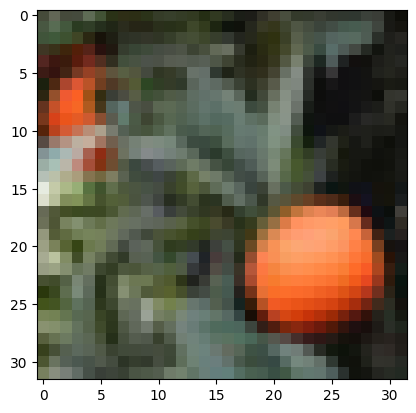

In [6]:
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
from tqdm import tqdm

def one_hot(y, n_values):
    return np.eye(n_values)[y.flatten()]

def reverse_one_hot(y):
    return np.argmax(y, axis=-1)

def random_horizontal_flip(X, prob=0.5):
    flipped = X.copy()
    flip_mask = np.random.rand(len(X)) < prob
    flipped[flip_mask] = flipped[flip_mask][:, :, ::-1, :]  # 좌우 반전
    return flipped


def show_image(X, y):
    print(y)
    plt.imshow(X, cmap='gray' if X.shape[2] == 1 else None)


np.random.seed(0)


X_train = np.load("train_data.npy")  # (50000, 3, 32, 32)
X_train = X_train.transpose(0, 2, 3, 1) / 255.0  # (50000, 32, 32, 3)

y_train = np.load("train_fine_labels.npy")
y_train = y_train.reshape(-1, 1)


num_total = X_train.shape[0]
num_val = num_total // 10
num_test = num_total // 10
num_train = num_total - num_val - num_test

indices = np.arange(num_total)
np.random.shuffle(indices)

train_idx = indices[:num_train]
val_idx = indices[num_train:num_train + num_val]
test_idx = indices[num_train + num_val:]

X_train_split = X_train[train_idx]
y_train_split = y_train[train_idx]

X_validate = X_train[val_idx]
y_validate = y_train[val_idx]

X_test = X_train[test_idx]
y_test = y_train[test_idx]




NUM_CLASSES = 100
y_train = one_hot(y_train, 100)
y_train_split = one_hot(y_train_split, NUM_CLASSES)
y_validate = one_hot(y_validate, NUM_CLASSES)
y_test = one_hot(y_test, NUM_CLASSES)

def show_image(X, y):
    print(y)
    plt.imshow(X, cmap='gray' if X.shape[2] == 1 else None)
    plt.show()

show_image(X_validate[0], y_validate[0])


In [23]:
class Layer:
    cache_X = None
    learn_rate = 0.001

    def forward(self, X):
        self.cache_X = X.copy()

    def backward(self, grad_in):
        raise NotImplementedError


def generate_regions(X, dim, stride):
    assert X.shape[1] >= dim
    assert X.shape[2] >= dim
    for fh, h in enumerate(range(0, X.shape[1] - dim + 1, stride)):
        for fw, w in enumerate(range(0, X.shape[2] - dim + 1, stride)):
            yield fh, fw, np.s_[:, h:h + dim, w:w + dim, :]


class Conv2D(Layer):
    W = None
    b = None
    out_nchannel = 0
    dim = 0
    stride = 0
    pad = 0

    def __init__(self, out_nchannel, dim, stride, pad):
        self.out_nchannel = out_nchannel
        self.dim = dim
        self.stride = stride
        self.pad = pad
        self.b = np.zeros(self.out_nchannel)

    def forward(self, X):
        super().forward(X)
        out_nchannel, dim, stride, pad = self.out_nchannel, self.dim, self.stride, self.pad
        if self.W is None:
            self.W = np.random.randn(
                dim, dim, X.shape[-1], out_nchannel) * np.sqrt(
                    2 / (X.shape[1] * X.shape[2] * X.shape[3]))
        W, b = self.W, self.b

        X = np.pad(X, ((0, ), (pad, ), (pad, ), (0, )))
        WX = np.zeros((len(X), (X.shape[1] - W.shape[0]) // stride + 1,
                       (X.shape[2] - W.shape[1]) // stride + 1, out_nchannel))

        for fh, fw, slice in generate_regions(X, dim, stride):
            WX[:, fh, fw, :] = np.tensordot(X[slice], W, axes=3)
        return WX + b

    def backward(self, grad_in):
        X = self.cache_X
        dX = np.zeros_like(X, dtype=float)
        dW = np.zeros_like(self.W)
        db = np.zeros_like(self.b)
        dim, stride, pad = self.dim, self.stride, self.pad
        X = np.pad(X, ((0, ), (pad, ), (pad, ), (0, )))
        dX_pad = np.zeros_like(X, dtype=float)

        for fh, fw, slice in generate_regions(X, dim, stride):
            grad_in_slice = grad_in[:, fh, fw, newaxis, newaxis, newaxis, :]
            dX_pad[slice] += np.sum(self.W * grad_in_slice, axis=-1)
            dW += np.sum(X[slice][..., newaxis] * grad_in_slice, axis=0)
            db += np.sum(grad_in_slice, axis=0).squeeze()
        dX = dX_pad[:, pad:-pad, pad:-pad, :] if pad > 0 else dX_pad
        self.W -= dW * self.learn_rate
        self.b -= db * self.learn_rate
        # print('dW mean=', np.mean(dW), '\ndb mean=', np.mean(db))
        return dX


class ReLU(Layer):

    def forward(self, X):
        super().forward(X)
        return np.maximum(X, 0)

    def backward(self, grad_in):
        dX = grad_in.copy()
        dX[self.cache_X <= 0] = 0
        return dX


class MaxPool2D(Layer):
    dim = 0
    stride = 0

    def __init__(self, dim, stride):
        self.dim = dim
        self.stride = stride

    def forward(self, X):
        super().forward(X)
        dim, stride = self.dim, self.stride
        out_shape = ((X.shape[1] - dim) // stride + 1,
                     (X.shape[2] - dim) // stride + 1, X.shape[3])
        y = np.zeros((len(X), ) + out_shape)
        for fh, fw, slice in generate_regions(X, dim, stride):
            y[:, fh, fw, :] = np.max(X[slice], axis=(1, 2))
        return y

    def backward(self, grad_in):
        X = self.cache_X
        dim, stride = self.dim, self.stride
        dX = np.zeros_like(X, dtype=float)
        for fh, fw, slice in generate_regions(X, dim, stride):
            xs = X[slice]
            indices = np.indices((xs.shape[0], xs.shape[-1]))
            max_indices = (indices[0], ) + np.unravel_index(
                xs.reshape((xs.shape[0], -1, xs.shape[-1])).argmax(axis=1),
                xs.shape[1:-1]) + (indices[1], )
            mask = np.zeros_like(xs)
            mask[max_indices] = 1
            dX[slice] += mask * grad_in[:, fh, newaxis, fw, newaxis, :]
        return dX


class Flatten(Layer):
    def forward(self, X):
        super().forward(X)
        return X.reshape((len(X), -1))

    def backward(self, grad_in):
        return grad_in.reshape(self.cache_X.shape)


class Dense(Layer):
    W = None
    b = None
    out_dim = 0

    def __init__(self, out_dim):
        self.out_dim = out_dim
        self.b = np.zeros(out_dim)

    def forward(self, X):
        super().forward(X)
        in_dim = X.shape[-1]
        if self.W is None:
            self.W = np.random.randn(in_dim, self.out_dim) * np.sqrt(
                2 / in_dim)
        return X @ self.W + self.b

    def backward(self, grad_in):
        X = self.cache_X
        dX = grad_in @ self.W.T
        dW = X.T @ grad_in
        db = np.sum(grad_in, axis=0)
        self.W -= dW * self.learn_rate
        self.b -= db * self.learn_rate
        return dX


def softmax(X, axis=-1, epsilon=1e-9):
    e_x = np.exp(X - np.max(X, axis=axis, keepdims=True))
    probs = e_x / e_x.sum(axis=axis, keepdims=True)
    return probs


class SoftmaxCrossEntropy(Layer):
    cache_grad = None

    def forward(self, X, y):
        super().forward(X)
        m = len(X)
        y_hat = softmax(X)
        loss = (-1 / m) * np.log(y_hat[y == 1]).sum()
        self.cache_grad = (y_hat - y) / m
        return y_hat, loss

    def backward(self, grad_in):
        return self.cache_grad


class Dropout(Layer):
    def __init__(self, rate):
        self.rate = rate
        self.mask = None

    def forward(self, X):
        self.mask = np.random.binomial(1, 1 - self.rate, size=X.shape)
        return X * self.mask

    def backward(self, grad_in):
        return grad_in * self.mask


In [24]:
class Model:
    layers = []
    learn_rate = 0

    def __init__(self, layers, learn_rate=0.001):
        for layer in layers:
            layer.learn_rate = learn_rate
        self.layers = layers
        self.learn_rate = learn_rate

    def forward(self, X, y=None):
        m = len(X)
        for layer in self.layers[:-1]:
            X = layer.forward(X)
        if y is None:
            return softmax(X)
        assert len(y) == m
        y_hat, loss = self.layers[-1].forward(X, y)
        return y_hat, loss

    def backward(self):
        grad = 1
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def fit(self,
            X_train,
            y_train,
            X_validate,
            y_validate,
            epochs=1,
            batch_size=32):
        n_sample = len(X_train)
        n_batch = (n_sample - 1) // batch_size + 1
        y_pred = np.zeros_like(y_train)
        for epoch in range(epochs):
            print(f"Epoch {epoch+1} ================")
            with tqdm(total=n_batch) as t:
                tot_loss = tot_acc = 0
                for i in range(n_batch):
                    batch = range(batch_size * i,
                                  min(batch_size * (i + 1), n_sample))

                    y_hat, loss = self.forward(random_horizontal_flip(X_train[batch]), y_train[batch])
                    acc = (1 / len(batch)) * np.sum(
                        reverse_one_hot(y_hat) == reverse_one_hot(
                            y_train[batch]))
                    y_pred[batch] = y_hat

                    grad = self.backward()

                    tot_loss += loss
                    tot_acc += acc
                    if (i + 1) % 32 == 0 or i + 1 == n_batch:
                        t.set_postfix({
                            'avg_loss': tot_loss / (i + 1),
                            'avg_accuracy': tot_acc / (i + 1),
                            'max_abs_gradient': np.max(abs(grad))
                        })
                        cur_n_batch = i % 32 + 1
                        t.update(cur_n_batch)
            print("Validation:")
            val_y_hat, val_loss, acc = self.evaluate(X_validate, y_validate)
            print(f"loss: {val_loss}, accuracy: {acc}")



    def predict(self, X, batch_size=32):
        y_pred = []
        n_sample = len(X)
        n_batch = (n_sample - 1) // batch_size + 1
        for i in tqdm(range(n_batch)):
            batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
            y_hat = self.forward(X[batch])
            y_pred.append(y_hat)
        return np.concatenate(y_pred)

    def evaluate(self, X, y, batch_size=32):
        y_pred = []
        n_sample = len(X)
        n_batch = (n_sample - 1) // batch_size + 1
        tot_loss = 0
        correct = 0
        for i in tqdm(range(n_batch)):
            batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
            y_hat, loss = self.forward(X[batch], y[batch])
            y_pred.append(y_hat)
            tot_loss += loss
            correct += np.sum(
                reverse_one_hot(y_hat) == reverse_one_hot(y[batch])
            )
        accuracy = correct / n_sample
        return np.concatenate(y_pred), tot_loss / n_batch, accuracy

    def get_weights(self):
        weights = []
        for layer in self.layers:
            if hasattr(layer, 'W'):
                weights.append(layer.W)
            if hasattr(layer, 'b'):
                weights.append(layer.b)
        return weights

    def set_weights(self, weights):
        weight_iter = iter(weights)
        for layer in self.layers:
            if hasattr(layer, 'W'):
                layer.W = np.array(next(weight_iter))
            if hasattr(layer, 'b'):
                layer.b = np.array(next(weight_iter))


In [25]:
np.random.seed(0)   ##deterministic weights get하기

model = Model([
    Conv2D(32, 3, 1, 1),
    ReLU(),
    MaxPool2D(2, 2),
    Conv2D(64, 3, 1, 1),
    ReLU(),
    Dropout(0.3),
    MaxPool2D(2, 2),
    Conv2D(128, 3, 1, 1),
    ReLU(),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(512),#512, relu 추가
    #ReLU(),
    # Dropout(0.3),
    Dense(256),#256, relu 추가
    Dense(128),
    Dense(100),
    SoftmaxCrossEntropy()
],
              learn_rate=0.02) #15% -> 0.01

# model.predict(X_train[0:1]) ## to initialize the weights
# model.get_weights()[0][0][0][0]




In [26]:
#model.fit(X_train, y_train, X_validate, y_validate, epochs=10)
X_train_flip = X_train_split[:, :, ::-1, :]  # 좌우 반전
y_train_flip = y_train_split.copy()         # 라벨은 동일

X_train_aug = np.concatenate([X_train_split, X_train_flip], axis=0)
y_train_aug = np.concatenate([y_train_split, y_train_flip], axis=0)

model.fit(X_train_aug, y_train_aug, X_validate, y_validate, epochs=20)

Epoch 1 ================


100%|██████████| 2500/2500 [29:35<00:00,  1.41it/s, avg_loss=4.17, avg_accuracy=0.0692, max_abs_gradient=0.00806]


Validation:


100%|██████████| 157/157 [00:04<00:00, 34.35it/s]


loss: 3.7273405900509333, accuracy: 0.127
Epoch 2 ================


100%|██████████| 2500/2500 [29:39<00:00,  1.40it/s, avg_loss=3.4, avg_accuracy=0.193, max_abs_gradient=0.011]   


Validation:


100%|██████████| 157/157 [00:04<00:00, 34.18it/s]


loss: 3.2114055010430036, accuracy: 0.2296
Epoch 3 ================


100%|██████████| 2500/2500 [29:21<00:00,  1.42it/s, avg_loss=2.93, avg_accuracy=0.28, max_abs_gradient=0.019]  


Validation:


100%|██████████| 157/157 [00:04<00:00, 34.67it/s]


loss: 2.8851637349067385, accuracy: 0.2956
Epoch 4 ================


100%|██████████| 2500/2500 [29:36<00:00,  1.41it/s, avg_loss=2.62, avg_accuracy=0.342, max_abs_gradient=0.019] 


Validation:


100%|██████████| 157/157 [00:04<00:00, 33.97it/s]


loss: 2.7433631554054276, accuracy: 0.3298
Epoch 5 ================


100%|██████████| 2500/2500 [31:49<00:00,  1.31it/s, avg_loss=2.39, avg_accuracy=0.391, max_abs_gradient=0.0221]


Validation:


100%|██████████| 157/157 [00:04<00:00, 34.56it/s]


loss: 2.675506597208494, accuracy: 0.35
Epoch 6 ================


 72%|███████▏  | 1792/2500 [21:16<08:24,  1.40it/s, avg_loss=2.22, avg_accuracy=0.425, max_abs_gradient=0.0386]


KeyboardInterrupt: 

In [ ]:

# conv layer 정의
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_channels=in_planes, 
                     out_channels=out_planes, 
                     kernel_size=3, 
                     stride=stride,
                     padding=1,
                     bias=False,
                     )
    
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_channels=in_planes, 
                     out_channels=out_planes, 
                     kernel_size=1, 
                     stride=stride,
                     bias=False,
                     )

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(
            inplanes,
            planes,
            stride
        )
        self.bn1=nn.BatchNorm2d(planes) # resnet은 모든 conv 다음 bn을 수행함.
        self.relu = nn.ReLU(inplace=True) 
        self.conv2 = conv3x3(planes, planes) # stride는 무조건 1임. (첫 layer에서만 수정함.)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample # Resnet 모듈에서 결정
        self.stride = stride

    def forward(self, x):
        identity = x # x값을 미리 저장 

        out = self.conv1(x) 
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None: # dim이 똑같지 않다면 downsampling 수행 (x와 conv layer를 거친 값과의 차원 맞추기.)
            identity = self.downsample(x)

        out += identity 
        out = self.relu(out)

        return out

# 50개 이상의 layer를 가진 ResNet architecture에서 computational efficiency를 증가시키기 위해 3x3 convolution layer 앞뒤로 1x1 convolution layer를 추가한 Bottleneck module
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride) # 절반으로 줄인다면 stride=2
        self.bn2 = nn.BatchNorm2d(planes)
        # resnet에서 bottleneck layer를 거친 이후, depth를 항상 4배 증가시킴 (논문에서 그렇게 진행함)
        # 리소스 소모가 커지지만 더 좋았나봄
        self.conv3 = conv1x1(planes, planes * self.expansion) 
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=100, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
